# Load in Packages

In [125]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.colors import PowerNorm
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter
from skimage.draw import disk
from scipy.optimize import curve_fit
from scipy import signal
from scipy.fft import fft, fftshift
#from lmfit import Parameters, minimize, report_fit
from obspy.imaging.cm import viridis_white
import cmocean
import xarray as xr
from math import nan
import multiprocessing

import sys, os
sys.path.append(os.path.abspath("R:\Lawson\mpes-analysis"))  # or full path to project

from Loader import DataLoader
from Main import main
from Manager import DataHandler, FigureHandler, PlotHandler, ValueHandler, SliderManager, EventHandler, CheckButtonManager, ClickButtonManager
import mpes
from mpes import cmap_LTL, cmap_LTL2
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the Data
### Specify Filename and Path. Load the Data

In [130]:
# Specify datapath, filename, and [Energy, Delay] offsets to load.
data_path = 'R:\Lawson\Data\metis'
#data_path = '/Users/lawsonlloyd/Desktop/Data/metis'

filename, offsets = 'Scan162_RT_120x120x115x50_binned.h5', [0.8467, -120]
#filename, offsets = 'Scan162_RT_120x120x115x51_rebinned_newECAL.h5', [0.035, 0]
#filename, offsets = 'Scan177_120K_120x120x115_binned.h5', [0.363, 0]

filename, offsets = 'Scan186_120K_Static_120x120x200_binned.h5', [0.039, 0]
filename, offsets = 'Scan188_120K_120x120x115x77_binned.h5', [0.5660, -105]
#filename, offsets = 'Scan163_120K_101x101x131x77_binned_v3.h5',  [0, 0]

#filename, offsets = 'Scan0804_30K_Pprobe_Spump_binned.h5', [.5047, -102]

# filename, offsets = 'Scan1042_binned.h5', [-0.4, 0]
# filename, offsets = 'Scan1052_binned.h5', [0, 0]
# filename, offsets = 'Scan1058_binned.h5', [-2, 0]
# filename, offsets = 'Scan1060_binned.h5', [-4, 0]
# filename, offsets = 'Scan1062_binned.h5', [-5.5, 0]
# filename, offsets = 'Scan1063_binned.h5', [-4.5, 0]
# filename, offsets = 'Scan1064_binned.h5', [-4.75, 0]
# filename, offsets = 'Scan1076_binned.h5', [-0.4, 0]
#filename, offsets = 'Scan1095_binned.h5', [0, -55]
# filename, offsets = 'Scan1097_binned.h5', [0, 0]

filename, offsets = 'Scan1192_RT_NiI2_121x121x164x66_binned.h5', [0, 0]

# Load the Data
data_loader = DataLoader(data_path + '//' + filename, offsets = offsets)
I = data_loader.load()


The data shape is: (121, 121, 164, 66)
"R:\Lawson\Data\metis//Scan1192_RT_NiI2_121x121x164x66_binned.h5" has been loaded! Happy Analysis...


### Generate Normalized and Difference Data


In [131]:
# Truncate and Normalize Data, if desired.
#I = I.loc[{"delay":slice(-250,850)}]
I_res = I[:, :, :,1:-1]
I_res = I_res/np.max(I_res)

# Normalize Each Time Step to the Total Volume Counts, if desired
#I = I / I.sum(dim=('kx','ky','E'))
#I = I/np.max(I)

# Generate Difference Data (Pos - Neg Delay Times), if desired.
if "delay" in I.dims:
    I_diff = I - I.loc[{"delay":slice(-250,-100)}].mean(dim="delay")
    I_diff = I_diff/np.max(I_diff)


# Analysis and Visualization
### Launch Interactive GUI

In [132]:
%matplotlib qt

#main(I)

# run start python launch_gui_v0.py in terminal

### Overview Plot

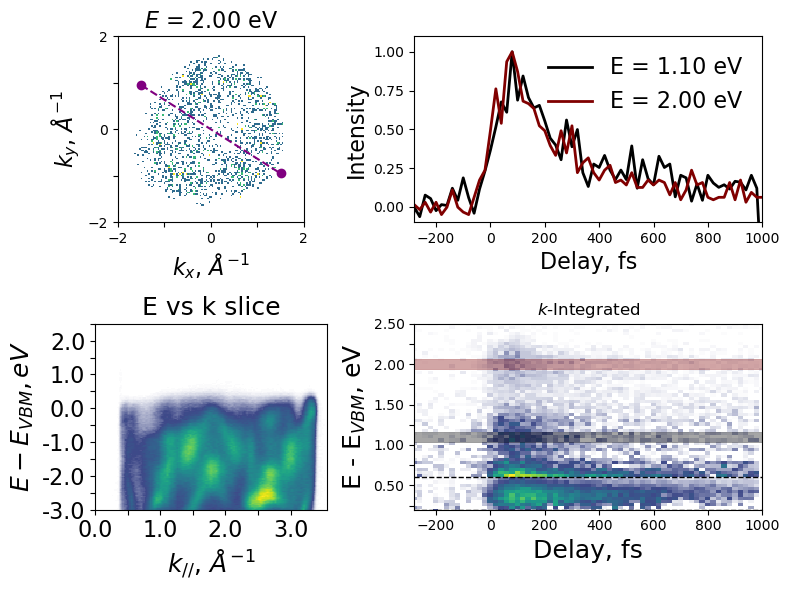

In [142]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 1.5], 'height_ratios':[1, 1]})
fig.set_size_inches(8, 6, forward=False)
axs = axs.flatten()

I_res = I
colors = ['black', 'maroon']

# Plot momentum map
mpes.plot_momentum_maps(
    I, E=2, E_int=.2, delays=500, delay_int=1000,
    fig = fig, ax = axs[0],
    cmap=cmap_LTL,
    panel_labels=False, fontsize=16,
    nrows=2, figsize=(8, 6)
)

# Plot time traces
E, E_int = [1.1, 2], .12 # Energies for Plotting Time Traces ; 1st Energy for MM
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
neg_delays = [-300, -100]

mpes.plot_time_traces(
    I, E, E_int, (kx, ky), (kx_int, ky_int),
    norm_trace=True, subtract_neg=True, neg_delays=neg_delays,
    fig = fig, ax = axs[1],
    colors = ['black', 'maroon'],
    fontsize=16
)
axs[1].set_ylim(-0.1, 1.1)

# Plot k - E (arbitrary Cut)
k_start, k_end = (-1.5, 0.95), (1.5, -0.95)
mpes.plot_k_cut(I_res, k_start=k_start, k_end=k_end, ax = axs[2], fig = fig, E_enhance = None, ax2 = axs[0])

# Plot waterfall
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
mpes.plot_waterfall(
    I, kx, kx_int, ky, ky_int,
    fig = fig, ax = axs[3], subtract_neg = True,
    cmap=cmap_LTL, scale=[0,1], energy_limits=[0.2,2.5], E_enhance = .6
)
    
for i in np.arange(len(E)):
    mpes.add_rect(500, 2000, E[i], E_int, axs[3], edgecolor=colors[i], facecolor=colors[i], alpha = 0.35)

#mpes.save_figure(fig, name = f'test', image_format = 'pdf')

### Plot Momentum Maps at Constant Energy

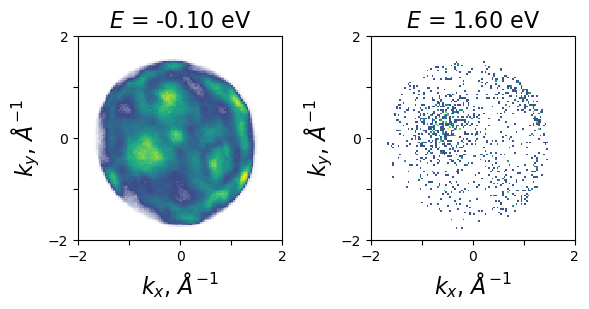

In [ ]:
cmap_plot = cmap_LTL

E, E_int = [-0.1, 1.6], .2
#delays, delay_int = 500, 1000

fig, ax, im = mpes.plot_momentum_maps(
    I_res, E=E, E_int=E_int, delays=None, delay_int=None,
    cmap=cmap_LTL, scale=[0, 1],
    fontsize=16, figsize=(6, 3), colorbar=False, panel_labels = False
)

#mpes.overlay_bz('rectangular', 3.508, 4.763, ax[0], 'black', rotation_deg = 0, repeat = 0)
#mpes.overlay_bz('hexagonal', 5.8, 5.8, ax[0], 'black', repeat = 2, rotation_deg = 90)
#mpes.save_figure(fig, name = f'scan186', image_format = 'svg')

### Waterfall Plot: Momentum-Integrated Dynamics

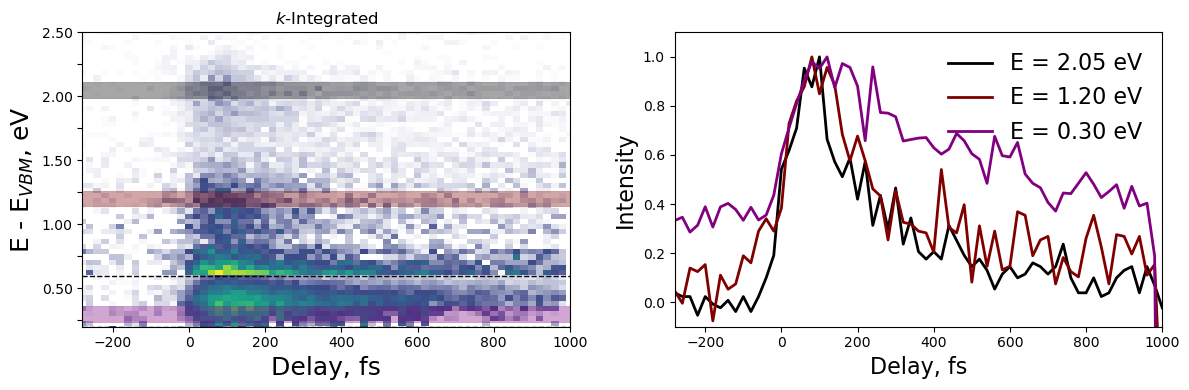

In [153]:
# Plot waterfall
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 4, forward=False)
axs.flatten()

E, E_int = [2.05, 1.2, 0.3], .12 # Energies for Plotting Time Traces ; 1st Energy for MM
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
colors = ['black', 'maroon', 'purple']
I_plot = I_res

# Plot waterfall
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
mpes.plot_waterfall(
    I, kx, kx_int, ky, ky_int,
    fig = fig, ax = axs[0], subtract_neg = True,
    cmap=cmap_LTL, scale=[0,1], energy_limits=[0.2,2.5], E_enhance = .6
)
    
# Plot time traces
neg_delays = [-320, -150]
mpes.plot_time_traces(
    I, E, E_int, (kx, ky), (kx_int, ky_int),
    norm_trace=True, subtract_neg=True, neg_delays=neg_delays,
    fig = fig, ax = axs[1],
    colors = colors,
    fontsize=16
)
axs[1].set_ylim(-0.1, 1.1)
for i in np.arange(len(E)):
    mpes.add_rect(500, 2000, E[i], E_int, axs[0], edgecolor=colors[i], facecolor=colors[i], alpha = 0.35)
colors = ['black', 'maroon']



### Plot & Fit Time Traces


Fit Results for model: biexp
----------------------------------------
A          =     0.9273 ±  0.2854
tau_decay1 =   189.5155 ± 124.0252
B          =     0.1943 ±  0.3528
tau_decay2 = 20000.0000 ± 813282.5293
----------------------------------------

Fit Results for model: biexp
----------------------------------------
A          =     1.1010 ±  0.1636
tau_decay1 =   176.1433 ± 54.1063
B          =     0.0468 ±  0.1921
tau_decay2 = 20000.0000 ± 1909375.3028
----------------------------------------


(-200.0, 999.0)

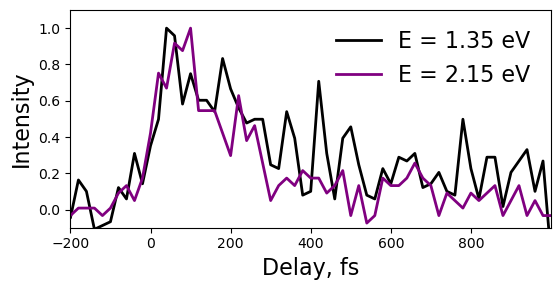

In [106]:
E, E_int = [1.35, 2.15], .12 # Energies for Plotting Time Traces ; 1st Energy for MM
(kx, ky), (kx_int, ky_int) = (0, 0), (4, 4) # Central (kx, ky) point and k-integration
norm_trace = True
subtract_neg = True
neg_delays = [-300, -120]
fwhm_IRF = 80
sigma_IRF = fwhm_IRF/2.355

fig, axs = plt.subplots()
fig.set_size_inches(6, 3, forward=False)
#axs = axs.flatten()

mpes.plot_time_traces(
    I, E, E_int, (kx, ky), (kx_int, ky_int),
    norm_trace, subtract_neg, neg_delays,
    fig = fig, ax = axs,
    colors = ['black', 'purple'],
    fontsize=16
)

### Do a Fitting: Choose model (input as string, e.g. 'monoexp') and input fit parameters (p0, bounds etc.)
delay_limits = (30, 999)
delay_axis_1 = I.delay.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

# Curve 1
time_trace = mpes.get_time_trace(I, E[0], E_int, (kx, ky), (kx_int, ky_int), norm_trace = True, subtract_neg = True, neg_delays = neg_delays)
time_trace = time_trace.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

model = 'biexp'
p0 = [1, 100, 1, 1000]
lower_bounds, upper_bounds = (0, 0, 0, 0), (10, 5000, 10, 20000)
popt, pcov, fit_curve_1 = mpes.fit_time_trace(model, delay_axis_1, time_trace, p0, [lower_bounds, upper_bounds], convolve = True, sigma_IRF = sigma_IRF)
ex_fit = mpes.print_fit_results(model, popt, pcov)

delay_limits = (-200, 999)
delay_axis_2 = I.delay.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

# Curve 2
time_trace = mpes.get_time_trace(I, E[1], E_int, (kx, ky), (kx_int, ky_int), norm_trace = True, subtract_neg = True, neg_delays = neg_delays)
time_trace = time_trace.loc[{"delay":slice(delay_limits[0], delay_limits[1])}].values

#model = 'exp_rise_monoexp_decay'
#p0 = [2, 10, 120] #C, tau_rise, tau_decay1)
#lower_bounds, upper_bounds = (0, 0, 0), (10, 2000, 10000)
model = 'biexp'
p0 = [1, 100, 1, 1000]
lower_bounds, upper_bounds = (0, 0, 0, 0), (10, 5000, 10, 20000)
popt, pcov, fit_curve_2 = mpes.fit_time_trace(model, delay_axis_2, time_trace, p0, [lower_bounds, upper_bounds], convolve = True, sigma_IRF = sigma_IRF)
cbm_fit = mpes.print_fit_results(model, popt, pcov)

#conv_model = mpes.make_convolved_model(mpes.exp_rise_monoexp_decay, delay_axis, 40)
#init_curve = conv_model(delay_axis, *p0)

# Plot Fits
#axs.plot(delay_axis_1, fit_curve_1, linestyle = 'dashed', color = 'green')
#axs.plot(delay_axis_2, fit_curve_2, linestyle = 'dashed', color = 'blue')
axs.set_ylim(-0.1,1.1)
axs.set_xlim(-200,delay_limits[1])

### Plot Energy vs Momentum

In [ ]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(8, 6, forward=False)
axs = axs.flatten()

# Plot momentum map
mpes.plot_momentum_maps(
    I_res, E=0, E_int=0.2, delays=100, delay_int=100,
    fig = fig, ax = axs[0],
    cmap=cmap_plot,
    panel_labels=False, fontsize=16,
    nrows=2, figsize=(12, 12)
)

# # Plot k - E (arbitrary Cut)
# k_start, k_end = (-1.5, 1), (1.6, -.7)
# #I_cut, k_vals, E_vals = mpes.get_k_cut(I_res.mean(dim="delay"), k_start=k_start, k_end=k_end)
# I_cut, k_vals, E_vals = mpes.get_k_cut(I_res, k_start=k_start, k_end=k_end)

# axs[0].plot(k_start[0], k_start[1], 'ro')
# axs[0].plot(k_end[0], k_end[1], 'ro')
# axs[0].plot([k_start[0], k_end[0]], [k_start[1], k_end[1]], color = 'red', linestyle = 'dashed')

# axs[1].pcolormesh(k_vals, E_vals, I_cut, shading='auto', cmap=cmap_LTL)
# axs[1].set_xlabel("k along cut ($\AA^{-1}$)")
# axs[1].set_ylabel("Energy (eV)")
# axs[1].set_title("E vs k slice", color = 'red')
# axs[1].set_ylim(-6,1)
# axs[1].set_aspect(1)

# # Plot k - E (arbitrary Cut)
# k_start, k_end = (-1.5, 0.9), (1.5, 0.9)
# #I_cut, k_vals, E_vals = mpes.get_k_cut(I_res.mean(dim="delay"), k_start=k_start, k_end=k_end)
# I_cut, k_vals, E_vals = mpes.get_k_cut(I_res, k_start=k_start, k_end=k_end)

# axs[0].plot(k_start[0], k_start[1], 'bo')
# axs[0].plot(k_end[0], k_end[1], 'bo')
# axs[0].plot([k_start[0], k_end[0]], [k_start[1], k_end[1]], color = 'blue', linestyle = 'dashed')

# axs[2].pcolormesh(k_vals, E_vals, I_cut, shading='auto', cmap=cmap_LTL)
# axs[2].set_xlabel("k along cut ($\AA^{-1}$)")
# axs[2].set_ylabel("Energy (eV)")
# axs[2].set_title("E vs k slice", color = 'blue')
# axs[2].set_ylim(-6,1)
# axs[2].set_aspect(1)

# Plot kx-E frame
(kx, ky), (kx_int, ky_int) = (0, .86), (.1, 0.1) # Central (kx, ky) point and k-integration
mpes.plot_kx_frame(
    I_res, ky, ky_int,
    E_enhance = 1,
    subtract_neg=True, neg_delays=[-500,-100],
    fig = fig, ax = axs[1],
    cmap = cmap_plot, scale=[0,1], energy_limits=[-3,0.5]
)
axs[0].axhline(ky, linestyle = 'dashed', color = 'grey')
# # Plot ky-E frame
# (kx, ky), (kx_int, ky_int) = (0, 0), (0.2, 0.2) # Central (kx, ky) point and k-integration
# mpes.plot_ky_frame(
#     I_res, ky, ky_int,
#     subtract_neg=True, neg_delays=[-500,-100],
#     fig = fig, ax = axs[1],
#     cmap = cmap_plot, scale=[0,1], energy_limits=[-3,.5]
#     )

fig.tight_layout()

# Data Treatment
### Define E = 0 wrt VBM

E_VBM = 0.004 +- 0.002 eV


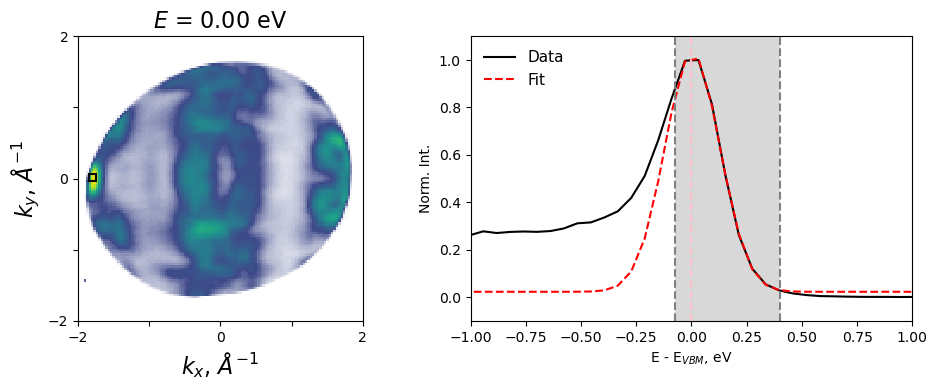

In [134]:
#%% Define E = 0 wrt VBM

%matplotlib inline

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios':[1]})
fig.set_size_inches(10, 4, forward=False)
ax = ax.flatten()

figure_file_name = 'vbm'
save_figure = False

### Plot EDCs at GAMMA vs time

(kx, ky), k_int = (-1.8, 0.01), 0.1
#(kx, ky), k_int = (0, 1.6), 0.1

delay, delay_int = -150, 200

edc_gamma = mpes.get_edc(I_res, kx, ky, (k_int, k_int), delay, delay_int)
edc_gamma = edc_gamma/np.max(edc_gamma)

mpes.plot_momentum_maps(
    I_res, E=0, E_int=.1, delays=500, delay_int=1000,
    fig = fig, ax = ax[0],
    cmap=cmap_LTL, scale=[0, 1],
    fontsize=16, figsize=(8, 6), colorbar=False, panel_labels = False
)
    
energy_window = [-0.075, 0.4]
p0 = [1, .02, 0.4, 0] # Fitting params initial guess [amp, center, width, offset]

mpes.find_E0(edc_gamma, energy_window, p0, fig, ax)

# cbar_ax = fig.add_axes([.51, 0.275, 0.025, 0.5])
rect = (Rectangle((kx-k_int/2, ky-k_int/2), k_int, k_int, linewidth=1.5,\
                         edgecolor='k', facecolor='None'))

rect1 = (Rectangle((energy_window[0], -.5), (energy_window[1]-energy_window[0]), 2, linewidth=1.5,\
                         edgecolor='none', facecolor='grey', alpha=0.3))

fig.axes[0].add_patch(rect)
fig.axes[1].add_patch(rect1)
ax[1].set_ylim(-0.1,1.1)
ax[1].axvline(energy_window[0], color = 'grey', linestyle = 'dashed')
ax[1].axvline(energy_window[1], color = 'grey', linestyle = 'dashed')
ax[1].axvline(0, color = 'pink', linestyle = 'dashed')


### Define t0 from Signal Rise


t0 = -0.5 +/- 2.4 fs
width = 23.8 +/- 4.8 fs


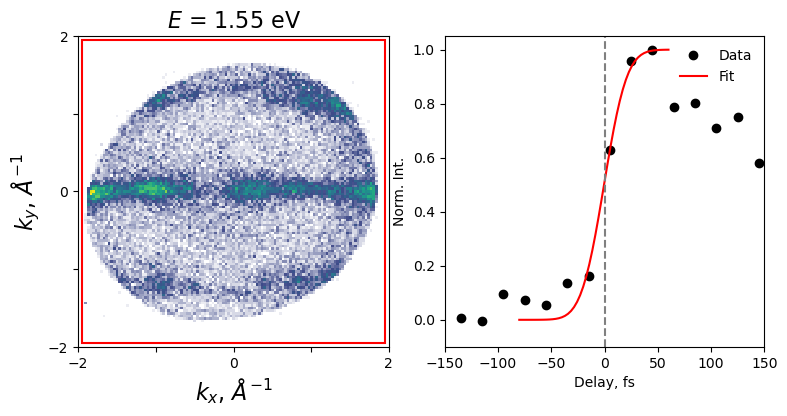

In [141]:
#%% Define t0 from Exciton Rise

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios':[1]})
fig.set_size_inches(8, 4, forward=False)
ax = ax.flatten()

figure_file_name = 'define_t0'
save_figure = False

### Plot EDCs at GAMMA vs time

(kx, ky), (kx_int, ky_int) = (0, 0), (3.9, 3.9)
#(kx, ky), (kx_int, ky_int) = (0, .7), (1.5, 0.5)
E, E_int = 1.55, 0.1
delay_limits = [-80, 60]

mpes.plot_momentum_maps(
    I_res, E=E, E_int=E_int, delays=200, delay_int=700,
    fig = fig, ax = ax[0],
    cmap=cmap_LTL, scale=[0, 1],
    fontsize=16, figsize=(8, 6), colorbar=False, panel_labels = False
)
    
rect = (Rectangle((kx-kx_int/2, ky-ky_int/2), kx_int, ky_int, linewidth=1.5,\
                         edgecolor='red', facecolor='None'))
fig.axes[0].add_patch(rect)

trace_ex = mpes.get_time_trace(I_res, E, E_int, (kx, ky), (kx_int, ky_int),  norm_trace = True, subtract_neg = True, neg_delays = (-350, -100))
mpes.find_t0(trace_ex, delay_limits, fig=fig, ax=ax)

if save_figure is True:
    mpes.save_figure(fig, name = f'test', image_format = 'pdf')